In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc
from IPython.display import Image, display
import os
import PIL

In [2]:
image_size = 224
num_classes = 151
model_name = "basic"
model_directory = os.getcwd() + "/SavedModel/" + model_name

model_filename = model_name + "Model.ckpt"
model_path = model_directory + "/" + model_filename

# Get Data

In [3]:
def list_files(dire):
    r= []
    names = []
    for root, dirs, files in os.walk(dire):

        for name in files:
            r.append(dire+'/' + name)
    return r

In [4]:
import os
training_list= list_files(os.getcwd() + '/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training')
#validation_list= list_files(os.getcwd() + '/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training')

training_label_list= list_files(os.getcwd() + '/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/annotations/training')
#validation_label_list= list_files(os.getcwd() + '/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/annotations/training')
print(os.path.isdir(os.getcwd() + '/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training'))

True


In [5]:
def imageToArray(filename, size):
    image = misc.imread(filename)
    print(filename)
    resize_image = misc.imresize(image, [size, size], interp='nearest')
    return np.array(resize_image)

In [6]:
def loadDataSet(data_list, label_list):
    print('bananas')
    dataset = []
    for filename in data_list:
        dataset.append(np.array([imageToArray(filename, image_size)]))
    #dataset = np.array([imageToArray(filename, image_size) for filename in data_list])
    dataset = np.array([imageToArray(filename, image_size) for filename in data_list])
    dataset_labels = np.array([imageToArray(filename, image_size) for filename in label_list])
    #datasetLabels = np.array([imageToArray(filename, image_size) for filename in label_list])
    print('bananasEnd')
    return dataset, dataset_labels

In [7]:
training_data, training_labels = loadDataSet(training_list[:1000], training_label_list[:1000])

bananas
C:\Users\Seth\CNNTutorials\6. Segmentation_Tutorial/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training/ADE_train_00000001.jpg
C:\Users\Seth\CNNTutorials\6. Segmentation_Tutorial/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training/ADE_train_00000002.jpg
C:\Users\Seth\CNNTutorials\6. Segmentation_Tutorial/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training/ADE_train_00000003.jpg
C:\Users\Seth\CNNTutorials\6. Segmentation_Tutorial/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training/ADE_train_00000004.jpg
C:\Users\Seth\CNNTutorials\6. Segmentation_Tutorial/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training/ADE_train_00000005.jpg
C:\Users\Seth\CNNTutorials\6. Segmentation_Tutorial/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training/ADE_train_00000006.jpg
C:\Users\Seth\CNNTutorials\6. Segmentation_Tutorial/Data_zoo/MIT_SceneParsing/ADEChallengeData2016/images/training/ADE_train_00000007.jpg
C:\Users\Seth\CNNTutorials

In [8]:
def createConvolutionLayerNew(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #\n",
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #\n",
    # returns convolution layer in graph
    #\n",
    #print("conv: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, features, depth],
                             initializer = tf.contrib.layers.xavier_initializer())

    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))

    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    print("wF: " + str(weights.get_shape()))
    print("bF: " + str(biases.get_shape()))
    added = tf.nn.bias_add(convolution, biases)

    return tf.nn.relu(added)

In [9]:
def createConvolutionLayer(x_input, _weights, _biases, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    init = tf.constant_initializer(np.transpose(_weights, (1, 0, 2, 3)), dtype=tf.float32)
    weights = tf.get_variable('weights', initializer=init,  shape=_weights.shape)
    
    init = tf.constant_initializer(_biases.reshape(-1), dtype=tf.float32)
    biases = tf.get_variable('biases', initializer=init,  shape=_biases.reshape(-1).shape)
    
    #print("conv: input size: " + str(x_input.get_shape()))
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    print("w: " + str(weights.get_shape()))
    print("b: " + str(biases.get_shape()))
    added = tf.nn.bias_add(convolution, biases)
    
    return tf.nn.relu(added)

In [10]:
def createConvolutionTransposeLayer(x_input, output_shape, weight_shape, stride=2):
        
    weights = tf.get_variable('weights', shape=weight_shape,
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[weight_shape[2]], initializer=tf.constant_initializer(0))
    print("xInp: " + str(x_input.get_shape()))
    print("xOut: " + str(output_shape.get_shape()))
    print("wTrans: " + str(weights.get_shape()))
    print("bTrans: " + str(biases.get_shape()))
    convolution = tf.nn.conv2d_transpose(x_input, weights, output_shape, strides=[1,stride,stride,1], padding = 'SAME')
    return tf.nn.bias_add(convolution, biases)

In [11]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    #print("fc: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [12]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLu in graph
    # 
    
    return tf.nn.relu(x_input)

In [13]:
def createPoolingLayer(x_input, kernel_size, pool_type):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    #print("pool: input size: " + str(x_input.get_shape()))
    #change to average pooling
    if pool_type == 'max':
        return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size, kernel_size, 1], padding='SAME')
    else:
        return tf.nn.avg_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size, kernel_size, 1], padding='SAME')
    

# Define VGG Model

In [14]:
#conv1.1 3x3, 64\n",
#conv1.2 3x3, 64\n",
#\n",
#pool /2\n",
#\n",
#conv2.1 3x3, 128\n",
#conv2.2 3x3, 128\n",
#\n",
#pool /2\n",
#\n",
#conv3.1 3x3, 256\n",
#conv3.2 3x3, 256\n",
#conv3.3 3x3, 256\n",
#conv3.4 3x3, 256\n",
#\n",
#pool / 2\n",
#\n",
#conv 4.1 3x3, 512\n",
#conv 4.2 3x3, 512\n",
#conv 4.3 3x3, 512\n",
#conv 4.4 3x3, 512\n",
#\n",
#pool /2\n",
#\n",
#FC 4k\n",
#FC 4k\n",
#FC 1000 (Or variable due to different image set)
def createVGG19(x_input, layer_weights, is_training):
    
    with tf.variable_scope('conv11'):
        kernel_weights, bias_weights = layer_weights[0][0][0][0][0]
        convolution_layer11 = createConvolutionLayer(x_input, kernel_weights, bias_weights, 3, 1, 64)
    with tf.variable_scope('conv12'):
        kernel_weights, bias_weights = layer_weights[2][0][0][0][0]
        convolution_layer12 = createConvolutionLayer(convolution_layer11, kernel_weights, bias_weights, 3, 64, 64)
        pooling_layer1 = createPoolingLayer(convolution_layer12, 2, 'avg')
        
    with tf.variable_scope('conv21'):
        kernel_weights, bias_weights = layer_weights[5][0][0][0][0]
        convolution_layer21 = createConvolutionLayer(pooling_layer1, kernel_weights, bias_weights, 3, 64, 128)
    with tf.variable_scope('conv22'):
        kernel_weights, bias_weights = layer_weights[7][0][0][0][0]
        convolution_layer22 = createConvolutionLayer(convolution_layer21, kernel_weights, bias_weights, 3, 128, 128)
        pooling_layer2 = createPoolingLayer(convolution_layer22, 2, 'avg')
        
    with tf.variable_scope('conv31'):
        kernel_weights, bias_weights = layer_weights[10][0][0][0][0]
        convolution_layer31 = createConvolutionLayer(pooling_layer2, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv32'):
        kernel_weights, bias_weights = layer_weights[12][0][0][0][0]
        convolution_layer32 = createConvolutionLayer(convolution_layer31, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv33'):
        kernel_weights, bias_weights = layer_weights[14][0][0][0][0]
        convolution_layer33 = createConvolutionLayer(convolution_layer32, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv34'):
        kernel_weights, bias_weights = layer_weights[16][0][0][0][0]
        convolution_layer34 = createConvolutionLayer(convolution_layer33, kernel_weights, bias_weights, 3, 1, 256)
        pooling_layer3 = createPoolingLayer(convolution_layer34, 2, 'avg')
        
    with tf.variable_scope('conv41'):
        kernel_weights, bias_weights = layer_weights[19][0][0][0][0]
        convolution_layer41 = createConvolutionLayer(pooling_layer3, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv42'):
        kernel_weights, bias_weights = layer_weights[21][0][0][0][0]
        convolution_layer42 = createConvolutionLayer(convolution_layer41, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv43'):
        kernel_weights, bias_weights = layer_weights[23][0][0][0][0]
        convolution_layer43 = createConvolutionLayer(convolution_layer42, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv44'):
        kernel_weights, bias_weights = layer_weights[25][0][0][0][0]
        convolution_layer44 = createConvolutionLayer(convolution_layer43, kernel_weights, bias_weights, 3, 1, 512)
        pooling_layer4 = createPoolingLayer(convolution_layer44, 2, 'avg')
    
    with tf.variable_scope('conv51'):
        kernel_weights, bias_weights = layer_weights[28][0][0][0][0]
        convolution_layer51 = createConvolutionLayer(pooling_layer4, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv52'):
        kernel_weights, bias_weights = layer_weights[30][0][0][0][0]
        convolution_layer52 = createConvolutionLayer(convolution_layer51, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv53'):
        kernel_weights, bias_weights = layer_weights[32][0][0][0][0]
        convolution_layer53 = createConvolutionLayer(convolution_layer52, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv54'):
        kernel_weights, bias_weights = layer_weights[34][0][0][0][0]
        convolution_layer54 = createConvolutionLayer(convolution_layer43, kernel_weights, bias_weights, 3, 1, 512)
        pooling_layer5 = createPoolingLayer(convolution_layer53, 2, 'max')
        
    with tf.variable_scope('fc1'):
        print('fc1')
        full_convolution_layer6 = createConvolutionLayerNew(pooling_layer5, 7, 512, 4096)
        fully_connected_relu6 = createLinearRectifier(full_convolution_layer6)
        fully_connected_relu6 = tf.cond(is_training, lambda: tf.nn.dropout(fully_connected_relu6, keep_prob=0.7), lambda: fully_connected_relu6)
        #need dropout
    with tf.variable_scope('fc2'):
        full_convolution_layer7 = createConvolutionLayerNew(fully_connected_relu6, 1, 4096, 4096)
        fully_connected_relu7 = createLinearRectifier(full_convolution_layer7)
        fully_connected_relu7 = tf.cond(is_training, lambda: tf.nn.dropout(fully_connected_relu7, keep_prob=0.7), lambda: fully_connected_relu7)
        # need dropout
    with tf.variable_scope('fc3'):
        full_convolution_layer8 = createConvolutionLayerNew(fully_connected_relu7, 1, 4096, num_classes)
        #full_convolution_layer8 = createConvolutionLayerNew(full_convolution_layer8, 3, 1, 512)
        
    return full_convolution_layer8, pooling_layer4, pooling_layer3

In [15]:
def createDeconvolutionNetwork(x_input, orig_input, pool_fuse1, pool_fuse2):
    with tf.variable_scope('dc1'):
        #determine size
        #conv layer
        deconvolution_layer1 = createConvolutionTransposeLayer(x_input, tf.shape(pool_fuse1), [4, 4, pool_fuse1.get_shape()[3].value, num_classes], stride=2)
        print("dc1: " + str(deconvolution_layer1.get_shape()))
        #fuse layer with pool 4
        fuse_layer1 = tf.add(pool_fuse1, deconvolution_layer1)
        print("fuse1: " + str(fuse_layer1.get_shape()))
    with tf.variable_scope('dc2'):
        #determine size
        #conv layer
        deconvolution_layer2 = createConvolutionTransposeLayer(fuse_layer1, tf.shape(pool_fuse2), [4, 4, pool_fuse2.get_shape()[3].value, pool_fuse1.get_shape()[3].value], stride=2)
        print("dc2: " + str(deconvolution_layer2.get_shape()))
        #fuse layer with pool 3
        fuse_layer2 = tf.add(pool_fuse2, deconvolution_layer2)
        print("fuse2: " + str(fuse_layer2.get_shape()))
    with tf.variable_scope('dc3'):
        #determine size
        shape1 = tf.shape(orig_input)
        shape2 = tf.pack([shape1[0], shape1[1], shape1[2], num_classes])
        #conv layer
        deconvolution_layer3 = createConvolutionTransposeLayer(fuse_layer2, shape2, [16, 16, num_classes, pool_fuse2.get_shape()[3].value], stride=8)
        print("output_layer: " + str(deconvolution_layer3.get_shape()))
        
    output = tf.argmax(deconvolution_layer3, dimension=3)
    
    return tf.expand_dims(output, dim=3), deconvolution_layer3

In [16]:
import scipy.io


def get_model_data(dir_path):
    filename = "imagenet-vgg-verydeep-19.mat"
    filepath = os.path.join(dir_path, filename)
    if not os.path.exists(filepath):
        raise IOError("VGG Model not found!")
    data = scipy.io.loadmat(filepath)
    return data

In [17]:
model_data = get_model_data("Model_zoo/")
mean = model_data['normalization'][0][0][0]
mean_pixel = np.mean(mean, axis=(0, 1))
weights = np.squeeze(model_data['layers'])

#Build the network
graph = tf.Graph()
with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3])
    y_output = tf.placeholder(tf.int32, shape=[None, image_size, image_size, 1])
    is_training = tf.placeholder(tf.bool)
    
    output, pool4, pool3 = createVGG19(x_input-mean_pixel, weights, is_training)
    prediction, logits = createDeconvolutionNetwork(output, x_input, pool4, pool3)
    
    learning_rate = .0001
    
    loss = tf.reduce_mean((tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf.squeeze(y_output, squeeze_dims=[3]))))
    optimizer = tf.train.AdamOptimizer(.0001).minimize(loss)

w: (3, 3, 3, 64)
b: (64,)
w: (3, 3, 64, 64)
b: (64,)
w: (3, 3, 64, 128)
b: (128,)
w: (3, 3, 128, 128)
b: (128,)
w: (3, 3, 128, 256)
b: (256,)
w: (3, 3, 256, 256)
b: (256,)
w: (3, 3, 256, 256)
b: (256,)
w: (3, 3, 256, 256)
b: (256,)
w: (3, 3, 256, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
fc1
wF: (7, 7, 512, 4096)
bF: (4096,)
wF: (1, 1, 4096, 4096)
bF: (4096,)
wF: (1, 1, 4096, 151)
bF: (151,)
xInp: (?, 7, 7, 151)
xOut: (4,)
wTrans: (4, 4, 512, 151)
bTrans: (512,)
dc1: (?, ?, ?, 512)
fuse1: (?, 14, 14, 512)
xInp: (?, 14, 14, 512)
xOut: (4,)
wTrans: (4, 4, 256, 512)
bTrans: (256,)
dc2: (?, ?, ?, 256)
fuse2: (?, 28, 28, 256)
xInp: (?, 28, 28, 256)
xOut: (4,)
wTrans: (16, 16, 151, 256)
bTrans: (151,)
output_layer: (?, ?, ?, 151)


In [18]:
import copy
def batch(x_data,y_data=None, batches=1):
    x_temp = copy.deepcopy(x_data)
    y_temp = copy.deepcopy(y_data)
    length = len(x_temp)
    
    # return iterations
    for index in range(0, length, batches):
        if y_temp is None:
            yield x_temp[index:min(index + batches, length)]
        else:
            yield x_temp[index:min(index + batches, length)], y_temp[index:min(index + batches, length)]

In [19]:
import time
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s
training_labels = np.reshape(training_labels, [-1, image_size, image_size, 1])

In [20]:
training_labels.shape

(1000, 224, 224, 1)

In [21]:
start = time.time()
train_loss_list = []
valid_loss_list = []
valid_loss_list = []
time_list = []
epoch_list = []
batch_size = 3
print("TRAINING ")

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for current_epoch in range(1):
        for x, y in batch(training_data, training_labels, batch_size):
            feed_dict = {x_input: x, y_output: y, is_training: True}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)

        #train_loss = lossFunction(get_predictions_in_batches(out, session), label_values)
        #train_loss_list.append(accuracy)
        [train_loss] = session.run([loss], feed_dict=feed_dict)
        print("Step: %d, Train_loss:%g" % (current_epoch, train_loss))
        #train_accuracy = accuracy.eval(feed_dict={x_input:train_x, y_output: train_y})
        #valid_accuracy = accuracy.eval(feed_dict={x_input:validation_x, y_output: validation_y})
        #train_loss = lossFunction(get_predictions_in_batches(x_validate, session), y_validate)
        #valid_loss_list.append(valid_loss)
        #if(current_epoch % 10 == 0):
        # validate every so often

        current_time = time.time() - start
        hours, minutes, seconds = getTime(current_time)

        print("Epoch[%3d] " % current_epoch + "%d" % hours + ":%1d" % minutes + ":%1d " % seconds + "%f " % train_loss + " %f " % learning_rate)

        #time_list.append(current_time)
        #epoch_list.append(current_epoch)
        
        # Evaluate on test dataset.
    #test_loss = lossFunction(get_predictions_in_batches(x_validate, session), y_validate)
    #print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
    #prediction = y_output.eval(feed_dict={x_input: validation_x})
    #[p_batch] = session.run([prediction_output], feed_dict = {x_input : batch_data,is_training : False})
    
    if not os.path.exists(model_directory):
        os.mkdir(model_directory)
    save_path = saver.save(session, model_path)
    

TRAINING 
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
ru

In [22]:
train_loss

3.5297666

In [60]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    load_path = saver.restore(session, model_path)
    [p] = session.run([prediction], feed_dict={x_input: training_data[14:16], is_training:False})

In [65]:
p.shape

(2, 224, 224, 1)

In [66]:
pred = np.squeeze(p, axis=3)

In [67]:
pred.shape

(2, 224, 224)

In [54]:
pred = np.reshape(pred, [224, 224, 1])

In [55]:
pred.shape

(224, 224, 1)

In [68]:
misc.imsave(os.path.join(os.getcwd() + "/SavedPredictions/", "test2" + ".png"), pred[0])

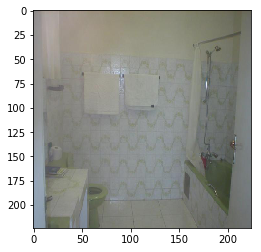

In [77]:
%matplotlib inline
img = training_data[15]

plt.imshow(img)

In [1]:
plt.imshow(pred[1])

NameError: name 'plt' is not defined